# Sentiment Analysis, using the TDSP methodology

# Imports

The following specific imports will help us perform text preprocessing and word embedding using Gensim and FastText.

Libraries:
- Gensim: A robust library for topic modeling and document similarity analysis. It is used here for text preprocessing and creating word embeddings.
- GitHub FastText: A library for efficient learning of word representations and sentence classification. It is used here to generate word embeddings.

In [19]:
#%pip install gensim

In [20]:
#%pip install git+https://github.com/facebookresearch/fastText.git

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata

plt.style.use('ggplot')

In [22]:
#The following imports are necessary for our Sentiment Analysis project and for data preprocessing, feature extraction, and model training.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re

# Feature extraction libraries
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

# 1.Data Collection

## The dataset used for our analysis is Amazon Fine Food Reviews.
This dataset consists of reviews of fine foods from Amazon. The data spans over a period of more than 10 years, containing all ~500,000 reviews up to October 2012. The reviews include product and user information, ratings, and plain text reviews. It also includes reviews from various Amazon categories.

### Dataset Contents
- **Reviews.csv**: Pulled from the corresponding SQLite table named `Reviews` in `database.sqlite`
- **database.sqlite**: Contains the table `Reviews`

### Key Information
- **Reviews Period**: October 1999 - October 2012
- **Number of Reviews**: 568,454
- **Number of Users**: 256,059
- **Number of Products**: 74,258
- **Active Reviewers**: 260 users with more than 50 reviews


In [23]:
# Reading the data from our CSV file to store it in a DataFrame
data = pd.read_csv('Reviews.csv')
print(data.shape)

(568454, 10)


# 2.Data Understanding

In [24]:
# Display concise summary of the DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [25]:
# Display the first five rows of the DataFrame 'data'
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [26]:
# Generate a summary of statistics for numerical columns
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


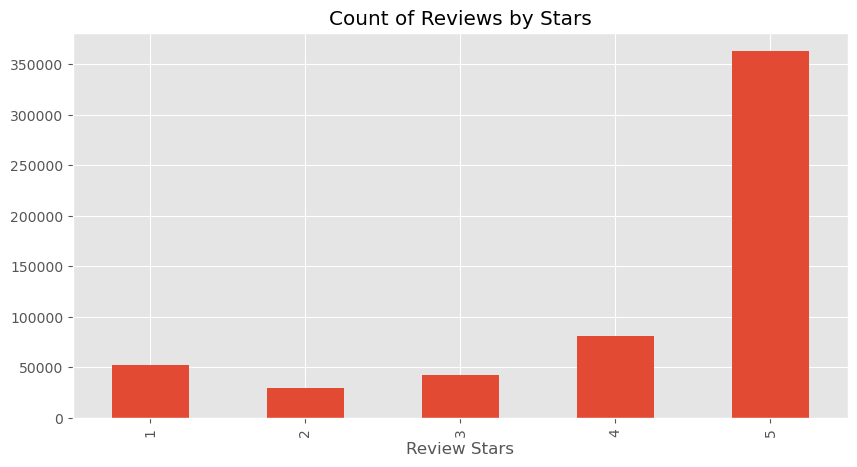

In [27]:
# Plotting the count of reviews by star ratings
ax = data['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [28]:
# Retrieve and print the text of the review from the 50th row as an example
example = data['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


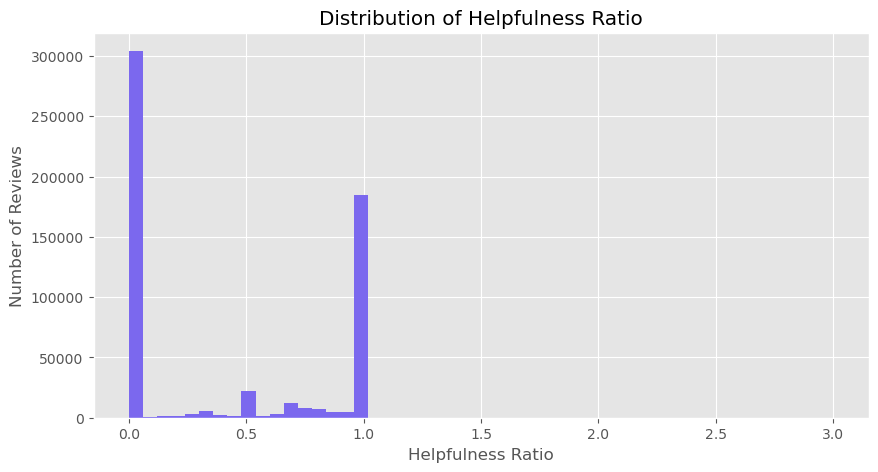

In [29]:
# Create a new column 'HelpfulnessRatio' by dividing 'HelpfulnessNumerator' by 'HelpfulnessDenominator',
# replacing 0 in the denominator with 1 to avoid division by zero.
data['HelpfulnessRatio'] = data['HelpfulnessNumerator'] / data['HelpfulnessDenominator'].replace(0, 1)
plt.figure(figsize=(10, 5))
plt.hist(data['HelpfulnessRatio'], bins=50, color='#7B68EE')
plt.title('Distribution of Helpfulness Ratio')
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Number of Reviews')
plt.show()

The chart displays the proportion of users who found each review helpful, calculated as the number of helpful votes divided by the total number of users who engaged with the review. A higher ratio indicates positive reception, while lower values suggest potential areas for improvement in the review's content.

# 3.Data Preparation

## 3.1 - Data Cleaning
- Checking for missing values and removing them.
- Remove all punctuation from the text, special characters, and digits to focus solely on words. This step helps in reducing noise and improving the performance of NLP models.
- Replace multiple spaces with a single space and trim leading/trailing spaces for consistency.
- Eliminate non-ASCII characters to ensure compatibility with NLP tools.
- Apply the cleaning function to the 'Text' column to create a new 'cleaned_text' column.

In [30]:
# Check for missing values
print(data.isnull().sum())

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
HelpfulnessRatio           0
dtype: int64


In [31]:
# Remove rows with missing values in 'Summary' or 'ProfileName' if necessary
data = data.dropna(subset=['Summary', 'ProfileName'])

In [32]:
def clean_text(text):
    # Normalize unicode characters and remove accents
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')
    
    # Convert text to lowercase for uniformity
    text = text.lower()
    
    # Remove ellipses (three or more periods) and replace with a space
    text = re.sub(r'\.{3,}', ' ', text)
    
    # Remove punctuation and special characters, keeping only words and spaces
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove non-ASCII characters to maintain compatibility
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Strip leading and trailing spaces from the text
    text = text.strip()
    
    return text

# Apply the clean_text function to the 'Text' column to create 'cleaned_text'
data['cleaned_text'] = data['Text'].apply(clean_text)

## 3.2 - Tokenization
- Split the cleaned text into individual words (tokens).
- Tokenization allows you to break down the text into smaller, meaningful units that can be processed and analyzed in further steps.

In [17]:
# Defining a list of common stop words that will be excluded from text processing.
stop_words_list = [
    # Articles
    "a", "an", "the",
    
    # Prepositions
    "in", "on", "at", "by",
    
    # Pronouns
    "he", "she", "it", "they",
    
    # Conjunctions
    "and", "but", "or",
    
    # Auxiliary Verbs
    "is", "are", "was", "were", "be", "been"
]

In [33]:
# Import necessary NLTK resources for tokenization and stop words
nltk.download('punkt')
nltk.download('stopwords')

def tokenize_text(text, stop_words_list):
    tokens = word_tokenize(text)
    
    # Load default NLTK English stop words
    default_stop_words = set(stopwords.words('english'))
    
    # Combine default stop words with your custom stop words list
    combined_stop_words = default_stop_words.union(set(stop_words_list))
    
    # Remove tokens that are in combined stop words list
    tokens = [token for token in tokens if token.lower() not in combined_stop_words]
    
    return tokens

data['tokens'] = data['cleaned_text'].apply(lambda text: tokenize_text(text, stop_words_list))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3.3 -Lemmatization
Our Lemmatization code will seve to do the following:
- Convert each word into its base or dictionary form using lemmatization.
- Lemmatization ensures that different forms of a word (e.g., "running", "ran", "runs") are grouped together as the base form ("run"), reducing dimensionality and improving model efficiency.

In [34]:
# Import necessary NLTK resources for stemming and lemmatization
# nltk.download('wordnet')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

data['stemmed_tokens'] = data['tokens'].apply(stem_tokens)
data['lemmatized_tokens'] = data['tokens'].apply(lemmatize_tokens)

This code implements Part-of-Speech (POS) tagging to identify the grammatical roles of words in the text, enhancing the analysis of the dataset. It uses NLTK resources to tag the tokenized text and stores the tags in a new column. Additionally, it counts the occurrences of each POS tag, providing insights into the linguistic features present in the documents.

In [36]:
# Import necessary NLTK resources for POS tagging
# nltk.download('averaged_perceptron_tagger')

def pos_tag_text(tokens):
    return nltk.pos_tag(tokens)

data['pos_tags'] = data['tokens'].apply(pos_tag_text)

# New function to count POS tags
def count_pos_tags(pos_tags):
    pos_counts = {}
    for _, pos in pos_tags:
        pos_counts[pos] = pos_counts.get(pos, 0) + 1
    return pos_counts

# Apply the counting function
data['pos_counts'] = data['pos_tags'].apply(count_pos_tags)

# Display the first few rows of the new POS tag count columns
print(data[[col for col in data.columns if col.startswith('pos_')]].head())


## 3.4 Feature Engineering
- Enhance the dataset by creating new features that improve the performance of machine learning models. This involves:
  - **Word Embeddings**: Utilizing pre-trained models like Word2Vec to represent words in continuous vector space, capturing semantic relationships and context between words.
  - **Principal Component Analysis (PCA)**: Reducing the dimensionality of the word embedding vectors to minimize noise and redundancy, making the dataset more manageable while retaining essential information.
  - **Aggregated Features**: Creating summary statistics (e.g., average word vector, maximum or minimum values) from word embeddings for each document, which helps encapsulate the overall meaning of the text.

- These techniques collectively transform the raw text data into informative, numerical features that enhance the model's ability to learn and make predictions effectively.


In [19]:
# Set display option to show all columns in the DataFrame output
pd.set_option('display.max_columns', None)

# Display the first 10 rows of the DataFrame to have a look at our available features
data.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,HelpfulnessRatio,cleaned_text,tokens,stemmed_tokens,lemmatized_tokens,pos_tags,pos_counts
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,i have bought several of the vitality canned d...,"[bought, several, vitality, canned, dog, food,...","[bought, sever, vital, can, dog, food, product...","[bought, several, vitality, canned, dog, food,...","[(bought, VBD), (several, JJ), (vitality, NN),...","{'VBD': 3, 'JJ': 4, 'NN': 8, 'NNS': 2, 'VBZ': ..."
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.0,product arrived labeled as jumbo salted peanut...,"[product, arrived, labeled, jumbo, salted, pea...","[product, arriv, label, jumbo, salt, peanut, p...","[product, arrived, labeled, jumbo, salted, pea...","[(product, NN), (arrived, VBD), (labeled, JJ),...","{'NN': 6, 'VBD': 2, 'JJ': 5, 'NNS': 2, 'RB': 1..."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,this is a confection that has been around a fe...,"[confection, around, centuries, light, pillowy...","[confect, around, centuri, light, pillowi, cit...","[confection, around, century, light, pillowy, ...","[(confection, NN), (around, IN), (centuries, N...","{'NN': 13, 'IN': 2, 'NNS': 7, 'JJ': 9, 'VBP': ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,if you are looking for the secret ingredient i...,"[looking, secret, ingredient, robitussin, beli...","[look, secret, ingredi, robitussin, believ, fo...","[looking, secret, ingredient, robitussin, beli...","[(looking, VBG), (secret, JJ), (ingredient, NN...","{'VBG': 1, 'JJ': 2, 'NN': 10, 'VBP': 1, 'VBN':..."
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0.0,great taffy at a great price there was a wide ...,"[great, taffy, great, price, wide, assortment,...","[great, taffi, great, price, wide, assort, yum...","[great, taffy, great, price, wide, assortment,...","[(great, JJ), (taffy, JJ), (great, JJ), (price...","{'JJ': 5, 'NN': 8}"
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,0.0,i got a wild hair for taffy and ordered this f...,"[got, wild, hair, taffy, ordered, five, pound,...","[got, wild, hair, taffi, order, five, pound, b...","[got, wild, hair, taffy, ordered, five, pound,...","[(got, VBD), (wild, JJ), (hair, NN), (taffy, N...","{'VBD': 5, 'JJ': 6, 'NN': 14, 'CD': 2, 'NNS': ..."
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,0.0,this saltwater taffy had great flavors and was...,"[saltwater, taffy, great, flavors, soft, chewy...","[saltwat, taffi, great, flavor, soft, chewi, c...","[saltwater, taffy, great, flavor, soft, chewy,...","[(saltwater, NN), (taffy, NN), (great, JJ), (f...","{'NN': 7, 'JJ': 5, 'NNS': 4, 'VBP': 2, 'RB': 4..."
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,0.0,this taffy is so good it is very soft and chew...,"[taffy, good, soft, chewy, flavors, amazing, w...","[taffi, good, soft, chewi, flavor, amaz, would...","[taffy, good, soft, chewy, flavor, amazing, wo...","[(taffy, RB), (good, JJ), (soft, JJ), (chewy, ...","{'RB': 2, 'JJ': 2, 'NN': 3, 'NNS': 1, 'VBG': 1..."
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,1.0,right now im mostly just sprouting this so my ...,"[right, im, mostly, sprouting, cats, eat, gras...","[right, im, m

The following code will be used for implementing Word2Vec using two architectures: CBOW (Continuous Bag of Words) and Skip-gram to capture word semantics in numerical form.

In [20]:
# Function to train a Word2Vec model using the specified architecture (CBOW or Skip-gram)

def train_word2vec(sentences, model_type='cbow'):
    if model_type == 'cbow':
        return Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)
    else:  # skip-gram
        return Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1)

# Train Word2Vec models using both CBOW and Skip-gram approaches
cbow_model = train_word2vec(data['tokens'], model_type='cbow')
skipgram_model = train_word2vec(data['tokens'], model_type='skipgram')

## 3.4.1 - 2D Visualization of Word2Vec Embeddings

In the next code, we're applying PCA (Principal Component Analysis) to reduce word vectors to 50 dimensions, simplifying the dataset while retaining variance.

We also used t-SNE (t-distributed Stochastic Neighbor Embedding) to further reduce the dimensionality to 2D for effective visualization.

Finally, we created a 2D scatter plot of the word embeddings, with annotations for each word, enabling intuitive understanding of word relationships and clusters based on their contextual similarities.

c:\Users\admin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\admin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


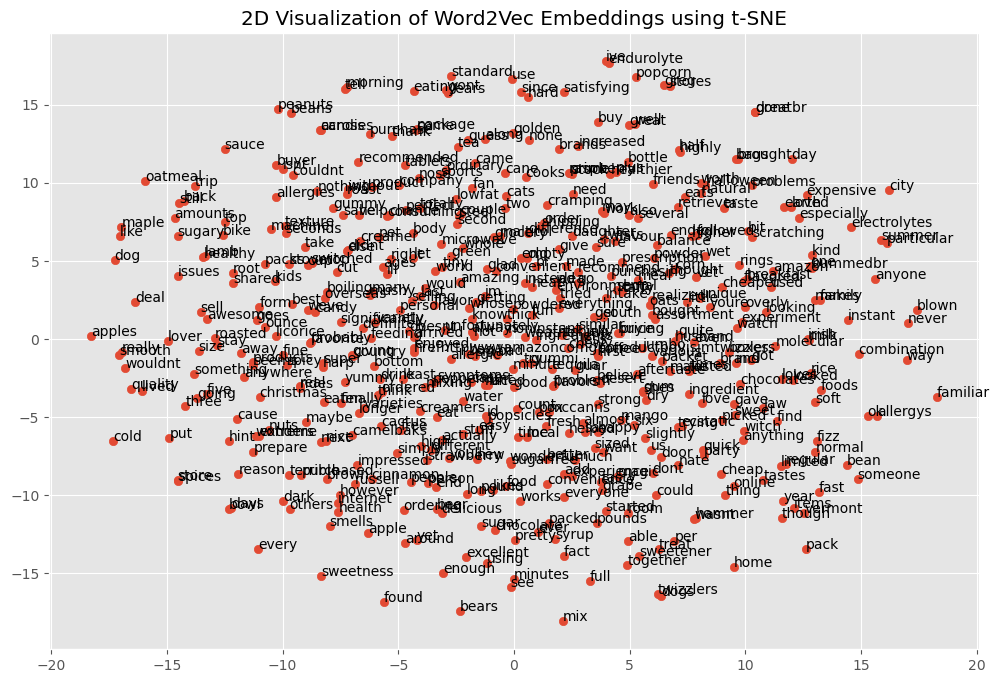

In [21]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming 'cbow_model' is your trained Word2Vec model (or KeyedVectors model)
# Pick the embedding model you're working with (either CBOW or Skip-gram)
embedding_model = cbow_model  # or skipgram_model

# Get vectors for a subset of words (to keep the visualization manageable)
if hasattr(embedding_model, 'key_to_index'):  # For KeyedVectors object, no need for .wv
    words = list(embedding_model.key_to_index.keys())[:500]  # First 500 words
    word_vectors = [embedding_model[word] for word in words]
else:  # For full Word2Vec model with 'wv' property
    words = list(embedding_model.wv.key_to_index.keys())[:500]  # First 500 words
    word_vectors = [embedding_model.wv[word] for word in words]

# Reduce dimensions with PCA to 50 components (optional before t-SNE)
pca = PCA(n_components=50)
word_vectors_pca = pca.fit_transform(word_vectors)

# Further reduce to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
word_vectors_tsne = tsne.fit_transform(word_vectors_pca)

# Plotting the words in 2D space
plt.figure(figsize=(12, 8))
plt.scatter(word_vectors_tsne[:, 0], word_vectors_tsne[:, 1])

# Annotate each word in the scatter plot
for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_tsne[i, 0], word_vectors_tsne[i, 1]))

plt.title("2D Visualization of Word2Vec Embeddings using t-SNE")
plt.show()

In this part, we extracted a list of words from the trained Word2Vec model, specifically accessing the key indices of the word vectors. For each word, retrieved its corresponding 100-dimensional embedding from the Word2Vec model, creating a structured representation of each word in a high-dimensional space.

Finally, we displayed the first 10 words along with their embeddings, providing a concise view of how words are numerically represented, facilitating further analysis or model building.

In [22]:
# Extract words and their corresponding 100-dimensional embeddings
words = list(embedding_model.wv.key_to_index.keys())
word_embeddings = [embedding_model.wv[word][:100] for word in words]

# Print the first 10 words and their 100-dimensional embeddings for brevity
for word, embedding in zip(words[:10], word_embeddings[:10]):
    print(f"Word: {word}\nEmbedding: {embedding}\n")


Word: food
Embedding: [-1.26429391e-03  1.55136234e-03  5.43888938e-03  9.13588703e-03
 -8.92508775e-03 -9.58739780e-03  7.07048131e-03  1.15083484e-02
 -5.64235076e-03 -4.59489040e-03  6.71351654e-03 -3.04027298e-03
 -4.75858198e-03  7.46785896e-03 -4.29160940e-03 -2.67138844e-03
  2.81143957e-03 -5.72368270e-04 -8.25566612e-03 -1.18667297e-02
  7.82814808e-03  5.99039532e-03  7.11308187e-03  2.42562761e-04
  6.06384547e-03 -3.71926674e-03 -2.32745055e-03  4.07340098e-03
 -8.66523013e-03 -4.14219731e-03 -6.07413612e-03 -6.35088072e-04
  9.58579872e-03 -8.17747880e-03 -2.45397724e-03 -1.85650992e-04
  8.13023373e-03 -7.36779906e-03 -8.36922729e-04 -7.14307744e-03
 -9.86280758e-03  4.00226051e-03 -9.07520857e-03 -4.05650912e-03
  1.18452171e-03 -9.90755158e-04 -8.38984735e-03  9.18869209e-03
  6.07558805e-03  1.02776745e-02 -7.69139314e-03  3.86958476e-03
 -4.72702179e-03  8.85725662e-04  7.52747105e-03 -3.63165489e-03
  5.46874106e-03 -7.14287721e-03 -5.25116920e-03  9.57127009e-03
 -7

## 3.4.2 - 3D Visualization of Word2Vec Embeddings

In the next code, we're extracting the first 500 words from the trained Word2Vec model to keep the visualization manageable.

We also used PCA to reduce the dimensionality of word vectors to 50 components as a preliminary step before applying t-SNE, which further reduced the dimensions to 3D for visualization purposes.

Finally, we created a 3D scatter plot to visualize the word embeddings. Each point in the plot represents a word in the reduced 3D space, with words annotated for identification, providing insight into the relationships and distributions of words based on their embeddings.

  Obtaining dependency information for FuzzyTM>=0.4.0 from https://files.pythonhosted.org/packages/2d/30/074bac7a25866a2807c1005c7852c0139ac22ba837871fc01f16df29b9dc/FuzzyTM-2.0.9-py3-none-any.whl.metadata
  Obtaining dependency information for pyfume from https://files.pythonhosted.org/packages/ed/ea/a3b120e251145dcdb10777f2bc5f18b1496fd999d705a178c1b0ad947ce1/pyFUME-0.3.4-py3-none-any.whl.metadata
  Obtaining dependency information for scipy>=1.7.0 from https://files.pythonhosted.org/packages/65/76/903324159e4a3566e518c558aeb21571d642f781d842d8dd0fd9c6b0645a/scipy-1.10.1-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/59.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/59.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/59.0 kB ? eta -:--:--
     ------ --------------------------------- 10.2/59.0 kB ? eta -:--:--
     ------------------- ------------------ 30.7/59.0 kB 330.3 kB/s eta 0:00:01
     -----------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.


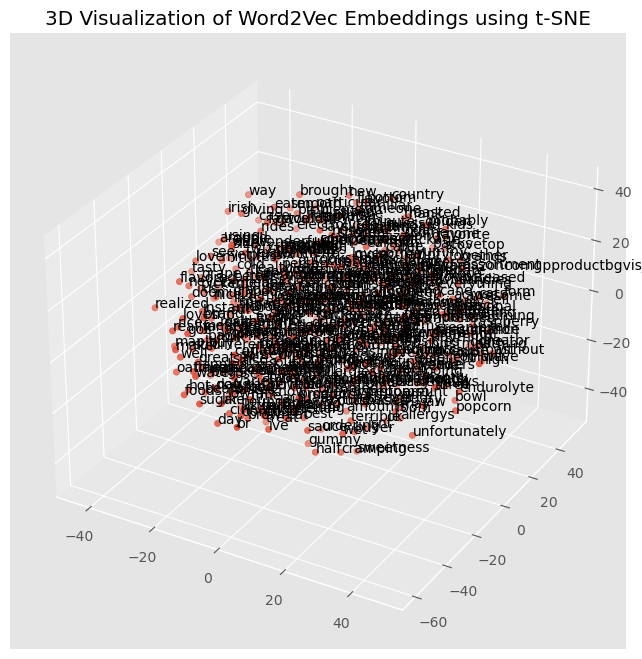

In [28]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming 'embedding_model' is your Word2Vec model

# Get vectors for a subset of words (to keep the visualization manageable)
words = list(embedding_model.wv.key_to_index.keys())[:500]  # Use the first 500 words
word_vectors = [embedding_model.wv[word] for word in words]

# Reduce dimensions with PCA (optional before t-SNE)
pca = PCA(n_components=50)
word_vectors_pca = pca.fit_transform(word_vectors)

# Further reduce to 3D using t-SNE
tsne = TSNE(n_components=3, random_state=0)
word_vectors_tsne = tsne.fit_transform(word_vectors_pca)

# Plotting in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(word_vectors_tsne[:, 0], word_vectors_tsne[:, 1], word_vectors_tsne[:, 2])

for i, word in enumerate(words):
    ax.text(word_vectors_tsne[i, 0], word_vectors_tsne[i, 1], word_vectors_tsne[i, 2], word)

plt.title("3D Visualization of Word2Vec Embeddings using t-SNE")
plt.show()


The next code uses the same approach, but will focus on visualizing the word embeddings of a limited set of words, specifically the first ten words from our Word2Vec model. 

This approach is particularly beneficial for creating a clear and concise representation of the relationships between these words. By using only ten words, we avoid cluttering the visualization, which allows for easier interpretation and better insights into the semantic similarities and distinctions among the selected words.

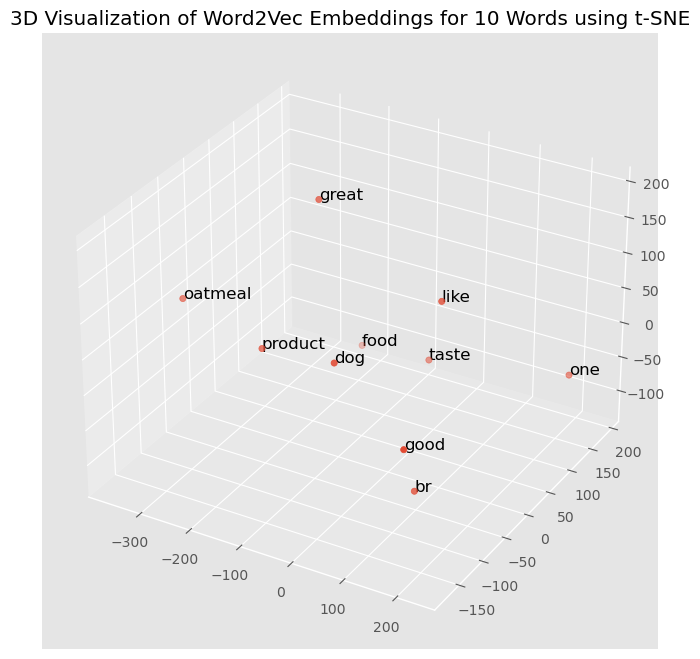

  Obtaining dependency information for FuzzyTM>=0.4.0 from https://files.pythonhosted.org/packages/2d/30/074bac7a25866a2807c1005c7852c0139ac22ba837871fc01f16df29b9dc/FuzzyTM-2.0.9-py3-none-any.whl.metadata
  Using cached FuzzyTM-2.0.9-py3-none-any.whl.metadata (7.9 kB)
  Obtaining dependency information for pyfume from https://files.pythonhosted.org/packages/ed/ea/a3b120e251145dcdb10777f2bc5f18b1496fd999d705a178c1b0ad947ce1/pyFUME-0.3.4-py3-none-any.whl.metadata
  Using cached pyFUME-0.3.4-py3-none-any.whl.metadata (9.7 kB)
  Obtaining dependency information for scipy>=1.7.0 from https://files.pythonhosted.org/packages/65/76/903324159e4a3566e518c558aeb21571d642f781d842d8dd0fd9c6b0645a/scipy-1.10.1-cp311-cp311-win_amd64.whl.metadata
  Using cached scipy-1.10.1-cp311-cp311-win_amd64.whl.metadata (58 kB)
  Obtaining dependency information for numpy>=1.18.5 from https://files.pythonhosted.org/packages/d8/ec/ebef2f7d7c28503f958f0f8b992e7ce606fb74f9e891199329d5f5f87404/numpy-1.24.4-cp311-cp3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.


In [29]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming 'embedding_model' is your Word2Vec model

# Get vectors for a subset of words (10 words for visualization)
words = list(embedding_model.wv.key_to_index.keys())[:10]  # Use the first 10 words
word_vectors = np.array([embedding_model.wv[word] for word in words])  # Convert list to NumPy array

# Directly reduce to 3D using t-SNE with adjusted perplexity
tsne = TSNE(n_components=3, random_state=0, perplexity=5)  # Set perplexity to less than 10
word_vectors_tsne = tsne.fit_transform(word_vectors)

# Plotting in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(word_vectors_tsne[:, 0], word_vectors_tsne[:, 1], word_vectors_tsne[:, 2])

for i, word in enumerate(words):
    ax.text(word_vectors_tsne[i, 0], word_vectors_tsne[i, 1], word_vectors_tsne[i, 2], word, size=12, zorder=1, color='k')

plt.title("3D Visualization of Word2Vec Embeddings for 10 Words using t-SNE")
plt.show()

    

Now, we will iterare through a list of words and their corresponding 3D vector representations obtained from the t-SNE dimensionality reduction technique. It prints each word alongside its 3D vector, allowing for a better understanding of how words are represented in a three-dimensional space after embedding.

In [25]:
# Iterate through each word and its corresponding 3D vector obtained from t-SNE
for word, vector in zip(words, word_vectors_tsne):
        # Print the word along with its 3D vector representation for better understanding of the embedding
    print(f"Word: {word}, 3D Vector: {vector}")

Word: food, 3D Vector: [ -89.39707  -28.97881 -152.15503]
Word: good, 3D Vector: [ 67.08522   63.940617 -68.09458 ]
Word: like, 3D Vector: [55.372623 24.754675 72.56113 ]
Word: br, 3D Vector: [ 32.342144 -92.484764  -7.322369]
Word: dog, 3D Vector: [-39.421883  48.67338  128.0665  ]
Word: oatmeal, 3D Vector: [-57.370937 -88.66067  102.72431 ]
Word: great, 3D Vector: [ 99.11478   30.063923 173.9359  ]
Word: taste, 3D Vector: [  95.468544  -76.632645 -147.76051 ]
Word: product, 3D Vector: [-42.64664   17.077023 -15.854834]
Word: one, 3D Vector: [ -52.471382  -94.3063   -219.67604 ]


For clarity and brevity, the next code prints the first 10 words along with their 100-dimensional embeddings, allowing for a quick inspection of the numerical representations associated with the words in the model. 

This is useful for understanding the nature of the embeddings and their dimensionality, which can be leveraged in various downstream tasks such as clustering, classification, or visualization.

In [27]:
# Extract words and their corresponding 100-dimensional embeddings
words = list(embedding_model.wv.key_to_index.keys())
word_embeddings = [embedding_model.wv[word][:100] for word in words]

# Print the first 10 words and their 100-dimensional embeddings for brevity
for word, embedding in zip(words[:10], word_embeddings[:10]):
    print(f"Word: {word}\nEmbedding: {embedding}\n")


Word: food
Embedding: [-0.01112351  0.01448785  0.00934129  0.01294226 -0.00736425 -0.03694498
  0.01044782  0.03645378 -0.01806583 -0.01232834 -0.00388867 -0.02204924
 -0.01132958  0.01185458 -0.00044427 -0.01444733 -0.00129127 -0.01828873
 -0.00278232 -0.03862844  0.01290854  0.01718931  0.01037078 -0.00698873
 -0.00139335  0.00107681 -0.01755704 -0.01122415 -0.02022985 -0.00388446
  0.01306197  0.00274629  0.0129007  -0.02051616 -0.00554046  0.02039064
  0.01503097 -0.02167249 -0.01600013 -0.03078591 -0.01082125 -0.01141218
 -0.00833212 -0.00267026  0.01229288 -0.01061347 -0.01713928  0.00474172
  0.01310282  0.01834576  0.00055468 -0.00592469 -0.0121991   0.00356807
 -0.00730898  0.00290436  0.01502992 -0.00737453 -0.02463476  0.01010387
  0.00904087  0.0080945  -0.01418557 -0.00754166 -0.01629388  0.01290482
  0.00519432  0.01804401 -0.01624918  0.01777052 -0.00604306  0.01319562
  0.01622996 -0.01521429  0.02583401  0.00614226  0.00321901  0.00058374
 -0.01378834 -0.00292336 -0.0

## 3.5 - Vectorization
- Convert the text data into numerical format (vectors) using techniques like:
  - **TF-IDF (Term Frequency-Inverse Document Frequency)**
  - **Word Embeddings (Word2Vec, GloVe, etc.)**
- This step is crucial to feed the textual data into machine learning algorithms for further analysis or model building.

## 3.5.1 - TF-IDF

In [31]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_text'])

## 3.5.2 - GloVe and Word Embeddings

In [32]:
### 3.3 GloVe and Word Embeddings

import os
import numpy as np
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors, Word2Vec

glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.word2vec.txt'

# Check if the GloVe file exists
if os.path.exists(glove_input_file):
    try:
        # Convert GloVe format to Word2Vec format
        glove2word2vec(glove_input_file, word2vec_output_file)
        
        # Load the converted file
        glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
        
        print("GloVe vectors loaded successfully.")
        embedding_model = glove_model
    except Exception as e:
        print(f"Error loading GloVe vectors: {str(e)}")
        print("Proceeding with Word2Vec model.")
        embedding_model = cbow_model  # or skipgram_model
else:
    print(f"GloVe file '{glove_input_file}' not found.")
    print("To use GloVe vectors:")
    print("1. Download glove.6B.zip from https://nlp.stanford.edu/projects/glove/")
    print("2. Unzip the file and place glove.6B.100d.txt in your working directory.")
    print("Proceeding with Word2Vec model.")
    embedding_model = cbow_model  # or skipgram_model

# Function to get document vector (works with both KeyedVectors and Word2Vec)
def get_doc_vector(tokens, model):
    vec = np.zeros(model.vector_size)
    count = 0
    for word in tokens:
        if isinstance(model, KeyedVectors):
            if word in model.key_to_index:
                vec += model[word]
                count += 1
        elif isinstance(model, Word2Vec):
            if word in model.wv.key_to_index:
                vec += model.wv[word]
                count += 1
    return vec / count if count > 0 else vec

# Apply to our data
data['embedding_vector'] = data['tokens'].apply(lambda x: get_doc_vector(x, embedding_model))

# Print some information about the embeddings
print(f"Embedding model type: {type(embedding_model)}")
print(f"Embedding vector size: {embedding_model.vector_size}")
print(f"Number of words in vocabulary: {len(embedding_model.key_to_index if isinstance(embedding_model, KeyedVectors) else embedding_model.wv.key_to_index)}")



GloVe file 'glove.6B.100d.txt' not found.
To use GloVe vectors:
1. Download glove.6B.zip from https://nlp.stanford.edu/projects/glove/
2. Unzip the file and place glove.6B.100d.txt in your working directory.
Proceeding with Word2Vec model.
Embedding model type: <class 'gensim.models.word2vec.Word2Vec'>
Embedding vector size: 100
Number of words in vocabulary: 1441


We're importing the library FastText that creates dense vector representations for words and also captures subword information, enabling it to generate embeddings for out-of-vocabulary words based on their character n-grams. 

This feature is particularly beneficial in our project, as it allows for improved performance in tasks such as text classification and semantic analysis, especially when dealing with diverse vocabulary or domain-specific terminology. By integrating FastText, we enhance the richness of our textual data representations, ultimately leading to better model performance and accuracy in downstream tasks.

In [41]:
#%pip install fasttext_wheel-0.9.2-cp311-cp311-win_amd64.whl

Processing c:\users\admin\desktop\studies\5ème\deeplearning\dlproject\fasttext_wheel-0.9.2-cp311-cp311-win_amd64.whlNote: you may need to restart the kernel to use updated packages.

  Obtaining dependency information for pybind11>=2.2 from https://files.pythonhosted.org/packages/13/2f/0f24b288e2ce56f51c920137620b4434a38fd80583dbbe24fc2a1656c388/pybind11-2.13.6-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/243.3 kB ? eta -:--:--
   ------ -------------------------------- 41.0/243.3 kB 991.0 kB/s eta 0:00:01
   -------------- ------------------------ 92.2/243.3 kB 871.5 kB/s eta 0:00:01
   ---------------------------- ----------- 174.1/243.3 kB 1.2 MB/s eta 0:00:01
   ------------------------------- -------- 194.6/243.3 kB 1.3 MB/s eta 0:00:01
   -------------------------------------- 243.3/243.3 kB 995.9 kB/s eta 0:00:00


This section focuses on extracting features using FastText embeddings from the cleaned text data. This is a word embedding technique that generates vector representations for words, capturing subword information which helps in better understanding the semantics of the text.

In [42]:
# Import the necessary libraries for FastText and numerical operations
import fasttext
import numpy as np

# 1. Write the cleaned text to a temporary file because FastText requires a file for unsupervised training.
data['cleaned_text'].to_csv('cleaned_text.txt', index=False, header=False)

# 2. Train the FastText model with cbow
fasttext_model = fasttext.train_unsupervised('cleaned_text.txt', model='cbow', dim=100)

# 3. Define a function to get the document (sentence) vector using FastText
def get_fasttext_document_vector(tokens, model):
    sentence = ' '.join(tokens)  # Convert the tokens back to a single sentence
    vector = model.get_sentence_vector(sentence)  # Get the vector representation for the entire sentence
    return vector

# 4. Apply this transformation to the tokenized data to get document vectors for each review
data['fasttext_vector'] = data['tokens'].apply(lambda x: get_fasttext_document_vector(x, fasttext_model))

# 5. Convert the column of vectors into a feature matrix
X_fasttext = np.stack(data['fasttext_vector'].values)  # Stack the vectors into a 2D numpy array

# Print example vector for one document to verify the output
print("Example FastText document vector:", X_fasttext[0])
print("Shape of feature matrix:", X_fasttext.shape)  # Output the shape of the feature matrix

Example FastText document vector: [-2.30242554e-02 -7.91482553e-02 -7.24117234e-02  1.06371604e-02
  3.96835096e-02 -1.43766582e-01 -1.50694087e-01 -2.71464512e-02
  6.61071837e-02  1.51546823e-03 -3.32569890e-02  1.66152269e-01
  2.89255492e-02 -5.10179214e-02 -5.09499991e-03  3.07304710e-02
  2.50703990e-02 -6.63185343e-02  5.02252541e-02  2.54748520e-02
 -4.47819866e-02  2.00625025e-02  1.46743506e-01  1.19807506e-02
  3.59462202e-02 -6.12554029e-02  1.46529421e-01  1.47860155e-01
 -3.44375521e-02  1.82770770e-02 -3.43445837e-02  3.24319340e-02
 -3.32702845e-02 -9.82482433e-02 -1.63938925e-01  1.02342248e-01
  1.63658487e-03  2.79418137e-02  8.13090578e-02  5.19285090e-02
  5.88690978e-04  1.08315974e-01  9.32561159e-02  1.34268224e-01
  1.05547616e-02 -9.72643048e-02  1.10418744e-01  1.24819465e-01
 -2.17927292e-01  2.03549802e-01  5.12540862e-02 -1.90171808e-01
 -2.12030292e-01  3.64157297e-02 -3.09586432e-02  2.70717982e-02
 -7.33947847e-03  1.13016451e-02 -3.14213969e-02  2.5467

This code is designed to visualize the 3D representation of word embeddings generated by the trained FastText model using t-distributed Stochastic Neighbor Embedding (t-SNE), allowing for an intuitive understanding of the semantic relationships between a subset of words in the FastText vocabulary.

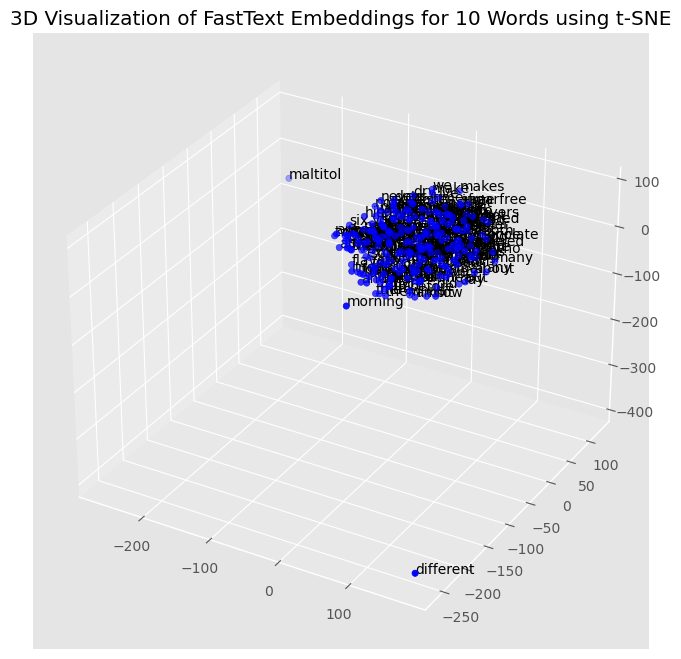

In [43]:
import numpy as np
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Assuming 'fasttext_model' is your trained FastText model

# Get vectors for a subset of words (e.g., 10 words for visualization)
words = list(fasttext_model.get_words())[:500]  # Use the first 10 words from FastText vocab
word_vectors = np.array([fasttext_model.get_word_vector(word) for word in words])  # Get word vectors

# Directly reduce to 3D using t-SNE with adjusted perplexity
tsne = TSNE(n_components=3, random_state=0, perplexity=5)  # Set perplexity to less than 10
word_vectors_tsne = tsne.fit_transform(word_vectors)

# Plotting the 3D visualization of FastText embeddings
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(word_vectors_tsne[:, 0], word_vectors_tsne[:, 1], word_vectors_tsne[:, 2], c='b', marker='o')

# Annotate each point with the word itself
for i, word in enumerate(words):
    ax.text(word_vectors_tsne[i, 0], word_vectors_tsne[i, 1], word_vectors_tsne[i, 2], word, size=10, zorder=1, color='k')

plt.title("3D Visualization of FastText Embeddings for 10 Words using t-SNE")
plt.show()

This code visualizes the 2D representation of word embeddings from the trained FastText model using t-SNE. It extracts the top 500 words and reduces their high-dimensional vectors to a 2D space for easier interpretation. The resulting scatter plot displays the words with annotations, highlighting their semantic relationships based on the embeddings.

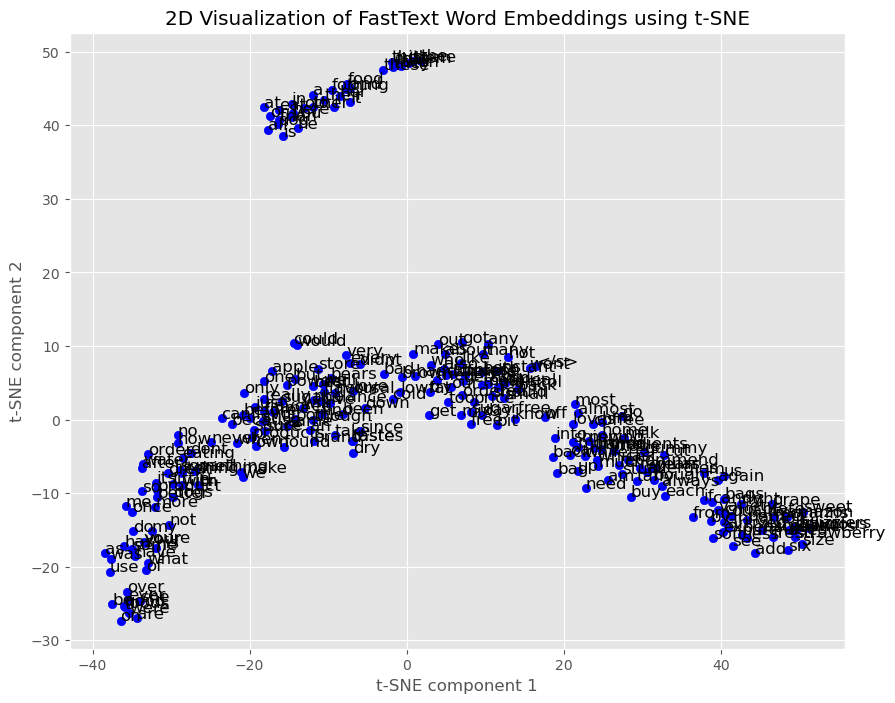

In [44]:

# 1. Get vectors for a subset of words (e.g., top 10 words for visualization)
words = list(fasttext_model.get_words())[:500]  # Select the first 10 words from the FastText vocabulary
word_vectors = np.array([fasttext_model.get_word_vector(word) for word in words])  # Get FastText word vectors

# 2. Reduce the vectors to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)  # Set perplexity to less than 10
word_vectors_tsne = tsne.fit_transform(word_vectors)

# 3. Create a scatter plot for the 2D t-SNE projected word vectors
plt.figure(figsize=(10, 8))
plt.scatter(word_vectors_tsne[:, 0], word_vectors_tsne[:, 1], c='blue')

# 4. Annotate the plot with the words
for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_tsne[i, 0], word_vectors_tsne[i, 1]), fontsize=12)

# Display the plot
plt.title("2D Visualization of FastText Word Embeddings using t-SNE")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.grid(True)
plt.show()

## 3.6 - Model Evaluation
We recognize that evaluation metrics are essential for assessing the effectiveness of our machine learning models, especially in tasks like sentiment analysis and classification. 

Metrics such as accuracy, precision, recall, and F1-score help us gain insights into the model's performance, allowing us to identify strengths and weaknesses. 

By analyzing these metrics, we can make informed decisions for model improvements and ensure that our models effectively achieve their intended goals.

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Assuming X_fasttext contains the FastText embeddings and y contains the labels
X = X_fasttext  # FastText embedding feature matrix
y = data['label']  # Replace with your actual label column in the data

# 1. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train a Random Forest classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# 3. Make predictions on the test set
y_pred = classifier.predict(X_test)

# 4. Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'micro' or 'macro' if appropriate
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
